In [1]:
%load_ext autoreload
%autoreload 2

import json

import numpy as np

from scipy import stats

from pathlib import Path

from overcast import models
from overcast import datasets
from overcast.models import ensembles
from overcast.visualization import plotting

import seaborn as sns
import matplotlib.pyplot as plt

rc = {
    "figure.constrained_layout.use": True,
    "figure.facecolor": "white",
    "axes.labelsize": 20,
    "axes.titlesize": 18,
    "legend.frameon": True,
    "figure.figsize": (6, 6),
    "legend.fontsize": 18,
    "legend.title_fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
}
_ = sns.set(style="whitegrid", palette="colorblind", rc=rc)

In [2]:
# "/users/ms21mmso/msc-project/overcast/output/jasmin-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-nn/dh-256_nco-5_nct-2_dp-2_ns-0.1_bt-0.0_ln-False_dr-0.09_sn-0.0_lr-0.0002_bs-224_ep-9",
# "/users/ms21mmso/msc-project/overcast/output/jasmin-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-nn/dh-96_nco-3_nct-9_dp-5_ns-0.11_bt-0.0_ln-False_dr-0.04_sn-0.0_lr-0.0002_bs-224_ep-9",
# "/users/ms21mmso/msc-project/overcast/output/jasmin-daily-four_outputs_liqcf_pacific_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-22_nct-27_dp-3_nh-8_ns-0.28_bt-0.0_ln-False_dr-0.42_sn-0.0_lr-0.0001_bs-128_ep-500",
# "/users/ms21mmso/msc-project/overcast/output/jasmin-daily-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-24_nct-7_dp-4_nh-8_ns-0.19_bt-0.0_ln-True_dr-0.16_sn-0.0_lr-0.0001_bs-160_ep-500",
# "/users/ms21mmso/msc-project/overcast/output/jasmin-MERRA_25kmres_2003_treatment-AOD_covariates-RH950-RH850-RH700-LTS-W500-SST_outcomes-re-COD-CWP_bins-1/appended-treatment-nn/dh-256_nco-24_nct-24_dp-3_ns-0.04_bt-0.0_ln-False_dr-0.2_sn-0.0_lr-0.0001_bs-2048_ep-300"
# "/users/ms21mmso/msc-project/overcast/output/jasmin-daily-MERRA_25kmres_2003_treatment-AOD_covariates-RH950-RH850-RH700-LTS-W500-SST_outcomes-re-COD-CWP_bins-1/appended-treatment-transformer/dh-256_nco-2_nct-30_dp-3_nh-8_ns-0.24_bt-0.0_ln-True_dr-0.04_sn-0.0_lr-0.0007000000000000001_bs-64_ep-500"

experiment = "jasmin-daily-MERRA_25kmres_2003_treatment-AOD_covariates-RH950-RH850-RH700-LTS-W500-SST_outcomes-re-COD-CWP_bins-1"
transformer = True if "daily" in experiment else False
parameters = "dh-256_nco-2_nct-30_dp-3_nh-8_ns-0.24_bt-0.0_ln-True_dr-0.04_sn-0.0_lr-0.0007000000000000001_bs-64_ep-500"
appended = "appended-treatment-transformer" if transformer else "appended-treatment-nn"

experiment_dir = Path(f"/users/ms21mmso/msc-project/overcast/output/{experiment}/{appended}/{parameters}")
config_path = experiment_dir / "config.json"
checkpoint_dir = experiment_dir / "checkpoints"

ensemble_dir = experiment_dir
fig_dir = Path("/users/ms21mmso/msc-project/overcast/results")

savefig = True

In [3]:
with open(config_path) as cp:
    config = json.load(cp)

dataset_name = config.get("dataset_name")
num_components_outcome = config.get("num_components_outcome")
num_components_treatment = config.get("num_components_treatment")
dim_hidden = config.get("dim_hidden")
depth = config.get("depth")
negative_slope = config.get("negative_slope")
beta = config.get("beta")
layer_norm = config.get("layer_norm")
dropout_rate = config.get("dropout_rate")
spectral_norm = config.get("spectral_norm")
learning_rate = config.get("learning_rate")
batch_size = config.get("batch_size")
epochs = config.get("epochs")
ensemble_size = config.get("ensemble_size")
num_heads = config.get("num_heads") if transformer is True else None

ds = {
    "test": datasets.DATASETS.get(dataset_name)(**config.get("ds_test")),
    "valid": datasets.DATASETS.get(dataset_name)(**config.get("ds_valid")),
    "train": datasets.DATASETS.get(dataset_name)(**config.get("ds_train")),
}

FileNotFoundError: [Errno 2] No such file or directory: '/users/ms21mmso/msc-project/overcast/output/jasmin-MERRA_25kmres_2003_treatment-AOD_covariates-RH950-RH850-RH700-LTS-W500-SST_outcomes-re-COD-CWP_bins-1/appended-treatment-nn/dh-256_nco-2_nct-30_dp-3_nh-8_ns-0.24_bt-0.0_ln-True_dr-0.04_sn-0.0_lr-0.0007000000000000001_bs-64_ep-500/config.json'

In [ ]:
TARGET_KEYS = dict((k, v) for (k,v) in enumerate(ds["test"].target_names))
print(TARGET_KEYS)

{0: 're', 1: 'COD', 2: 'CWP', 3: 'LPC'}


In [ ]:
if transformer: 
    ensemble = []
    for ensemble_id in range(ensemble_size):
        model_dir = checkpoint_dir / f"model-{ensemble_id}" / "mu"
        model = models.AppendedTreatmentAttentionNetwork(
            job_dir=model_dir,
            dim_input=ds["train"].dim_input,
            dim_treatment=ds["train"].dim_treatments,
            dim_output=ds["train"].dim_targets,
            num_components_outcome=num_components_outcome,
            num_components_treatment=num_components_treatment,
            dim_hidden=dim_hidden,
            depth=depth,
            num_heads=num_heads,
            negative_slope=negative_slope,
            beta=beta,
            layer_norm=layer_norm,
            spectral_norm=spectral_norm,
            dropout_rate=dropout_rate,
            num_examples=len(ds["train"]),
            learning_rate=learning_rate,
            batch_size=batch_size,
            epochs=epochs,
            patience=50,
            num_workers=0,
            seed=ensemble_id,
        )
        model.load()
        ensemble.append(model)
else:
    ensemble = []
    for ensemble_id in range(ensemble_size):
        model_dir = checkpoint_dir / f"model-{ensemble_id}" / "mu"
        model = models.AppendedTreatmentNeuralNetwork(
            job_dir=model_dir,
            architecture="resnet",
            dim_input=ds["train"].dim_input,
            dim_treatment=ds["train"].dim_treatments,
            dim_output=ds["train"].dim_targets,
            num_components_outcome=num_components_outcome,
            num_components_treatment=num_components_treatment,
            dim_hidden=dim_hidden,
            depth=depth,
            negative_slope=negative_slope,
            beta=beta,
            layer_norm=layer_norm,
            spectral_norm=spectral_norm,
            dropout_rate=dropout_rate,
            num_examples=len(ds["train"]),
            learning_rate=learning_rate,
            batch_size=batch_size,
            epochs=epochs,
            patience=epochs,
            num_workers=0,
            seed=ensemble_id,
        )
        model.load()
        ensemble.append(model)

2022-07-27 10:24:58,397 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /users/ms21mmso/msc-project/overcast/output/jasmin-daily-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-re-COD-CWP-LPC_bins-1/appended-treatment-transformer/dh-128_nco-24_nct-7_dp-4_nh-8_ns-0.19_bt-0.0_ln-True_dr-0.16_sn-0.0_lr-0.0001_bs-160_ep-500/checkpoints/model-0/mu/best_checkpoint.pt
/users/ms21mmso/miniconda3/envs/overcast/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
2022-07-27 10:25:00,257 overcast.models.core.AppendedTreatmentAttentionNetwork INFO: Loading saved checkpoint /users/ms21mmso/msc-project/overcast/output/jasmin-daily-four_outputs_liqcf_atlantic_treatment-AOD_covariates-RH900-RH850-RH700-LTS-EIS-W500-SST_outcomes-

## Scatterplots 

In [ ]:
means_ensemble = ensembles.predict_mean(ensemble, ds["test"], batch_size=None)
if transformer: 
    df_test = ds["test"].data_frame
    observed_outcomes = df_test.to_numpy()[:, -4:]
else: 
    observed_outcomes = ds["test"].targets_xfm.inverse_transform(ds["test"].targets)

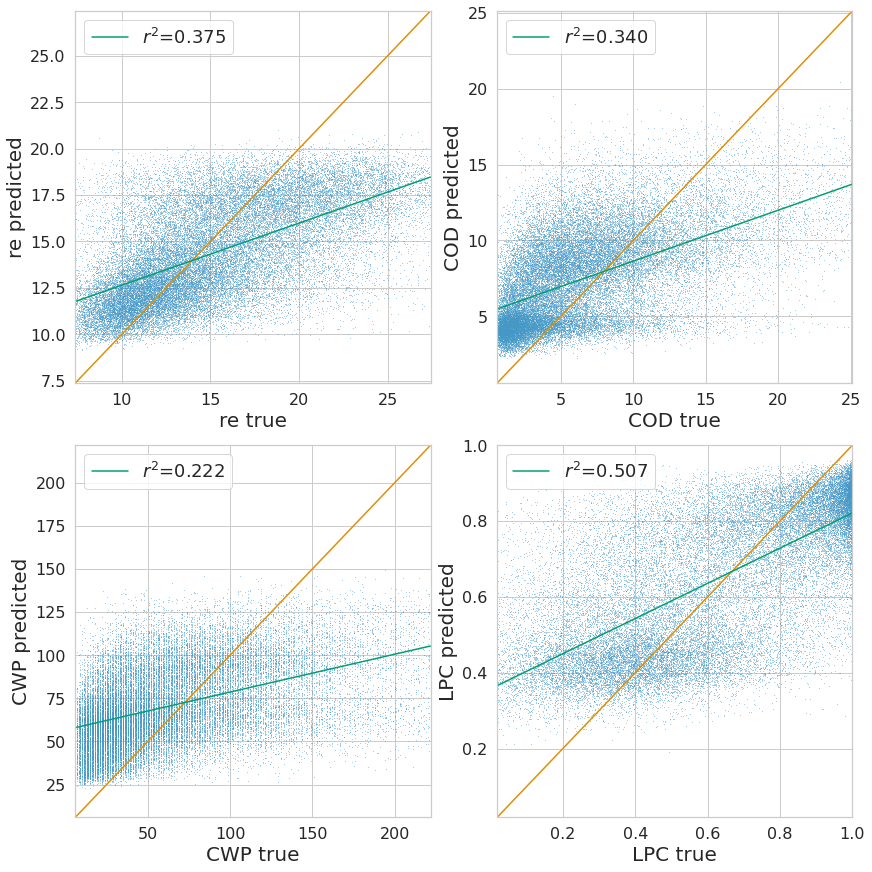

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(12, 12))
for idx_outcome in range(len(TARGET_KEYS)):
    if idx_outcome == 4:
        pass
    qs = np.quantile(observed_outcomes[:, idx_outcome], [0.01, 0.99])
    domain = np.arange(qs[0], qs[1], 0.01)
    slope, intercept, r, p, stderr = stats.linregress(
        observed_outcomes[:, idx_outcome], means_ensemble.mean(0)[:, idx_outcome]
    )
    i, j = idx_outcome//2, idx_outcome%2
    _ = sns.scatterplot(x=observed_outcomes[:, idx_outcome], y=means_ensemble.mean(0)[:, idx_outcome], s=0.5, ax=ax[i][j])
    _ = ax[i][j].plot(domain, domain, c="C1")
    _ = ax[i][j].plot(domain, domain * slope + intercept, c="C2", label=f"$r^2$={r**2:.03f}")
    _ = ax[i][j].set_xlim(qs)
    _ = ax[i][j].set_ylim(qs)
    _ = ax[i][j].set_xlabel(f"{TARGET_KEYS[idx_outcome]} true")
    _ = ax[i][j].set_ylabel(f"{TARGET_KEYS[idx_outcome]} predicted")
    _ = ax[i][j].legend(loc="upper left")
if savefig: 
    plt.savefig(f"{fig_dir}/{experiment}-{parameters}-scatter.png")
plt.show()

## $\Lambda  \to 1.0$

In [ ]:
if transformer:
    treatments = np.concatenate(ds["train"].treatments, axis=0)
    treatments = ds["train"].treatments_xfm.inverse_transform(treatments)
    treatments = np.quantile(
        treatments,
        q=np.arange(0, 1 + 1 / 32, 1 / 32),
    )[:-1]
else: 
    treatments = np.quantile(
        ds["train"].treatments_xfm.inverse_transform(ds["train"].treatments),
        q=np.arange(0, 1 + 1 / 32, 1 / 32),
    )[:-1]
apos_ensemble_path = ensemble_dir / "apos_ensemble.npy"
if not apos_ensemble_path.exists():
    capos_ensemble = ensembles.predict_capos(
        ensemble=ensemble, 
        dataset=ds["test"], 
        treatments=treatments, 
        batch_size=1 if transformer else 20000,
    )
    apos_ensemble = capos_ensemble.mean(2)
    np.save(apos_ensemble_path, apos_ensemble)
else:
    apos_ensemble = np.load(apos_ensemble_path)

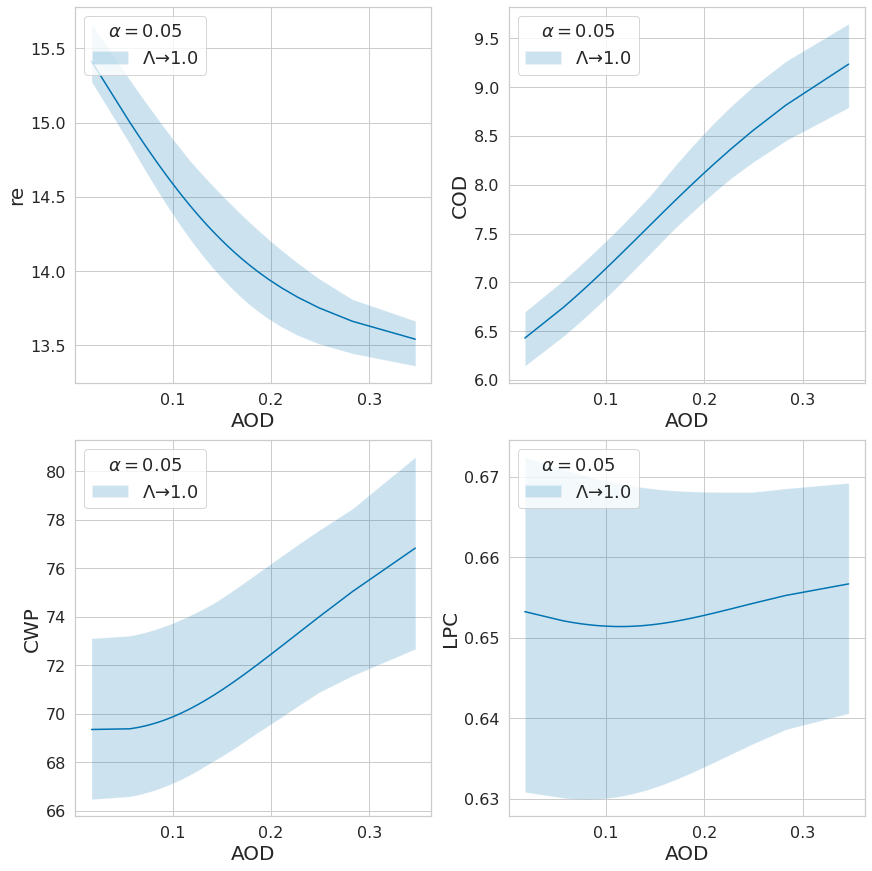

In [ ]:
alpha = 0.05

_, ax = plt.subplots(2, 2, figsize=(12, 12))
for idx_outcome in range(len(TARGET_KEYS)):
    if idx_outcome == 4:
        pass
    i, j = idx_outcome//2, idx_outcome%2
    _ = sns.lineplot(x=treatments, y=apos_ensemble[idx_outcome].mean(0), ax=ax[i][j])
    _ = ax[i][j].fill_between(
        x=treatments,
        y1=np.quantile(apos_ensemble[idx_outcome], 1 - alpha / 2, axis=0),
        y2=np.quantile(apos_ensemble[idx_outcome], alpha / 2, axis=0),
        alpha=0.2,
        label=r"$\Lambda \to 1.0 $",
    )
    _ = ax[i][j].legend(
        title=r"$\alpha=$" + f"{alpha}",
        loc="upper left",
    )
    _ = ax[i][j].set_xlabel(ds['train'].treatment_names[0])
    _ = ax[i][j].set_ylabel(TARGET_KEYS[idx_outcome])
if savefig: 
    plt.savefig(f"{fig_dir}/{experiment}-{parameters}-apo.pdf")
plt.show()